# General settings and loading of files

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from IPython.display import display, Math, Latex
from matplotlib import cm

%matplotlib inline

pd.options.display.max_columns = 40  # Affy csv has 30 fields
pd.options.display.mpl_style = 'default'

mpl.rc('figure', figsize=(13, 7))
mpl.rc('axes', titlesize=17, labelsize=14)
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('font', family='serif')
mpl.rc('legend', fontsize=15)

In [18]:
%run helpers/data_munging_functions.py
%run helpers/number_helpers.py

# Leer LAT-1 y discriminar Galanter Present vs. Missing

In [30]:
GALANTER_CSV = '~/tesina/galanter_SNPs.csv'
LAT1_CSV = '~/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv'  # 1.1Gb file!
# Smaller file for testing:
# LAT1_CSV_SMALL = "affy-LAT1/Axiom_GW_LAT.na35.annot.TRUNCATED.csv"

%run discriminate_present_vs_missing.py

galanter, present, missing = discriminate_present_vs_missing(
    GALANTER_CSV, LAT1_CSV, dumpdir="dumpfiles")

In [31]:
print("{} Galanter AIMs".format(len(galanter)))
print("{} present in LAT".format(len(present)))
print("{} missing in LAT".format(len(missing)))

446 Galanter AIMs
180 present in LAT
266 missing in LAT


In [120]:
chr_lengths = pd.read_csv('/home/juan/tesina/chr_len').set_index('chr')
chr_lengths = chr_lengths.drop(['X', 'Y'])
chr_lengths.index = chr_lengths.index.astype(int)
# max_len = chr_lengths.total_length.max()

### Distancias entre los AIMs por cromosoma

In [106]:
from collections import defaultdict

def SNP_distances_per_chromosome(df):
    """Returns the list of distances between markers, per chromosome"""
    distances = defaultdict(list)

    for chromosome in df.chr.unique():
        positions = df[df.chr == chromosome].position
        distances[chromosome] = np.array(distances_between_positions(positions))
        
#         chromosome_snps = df[df.chr == chromosome]
#         last_position_seen = 0
        
#         for position in chromosome_snps.sort('position').position:
#             distance_to_previous = position - last_position_seen
#             distances[chromosome].append(distance_to_previous)
#             last_position_seen = position
    
#     for chromosome in distances.keys():
#         distances[chromosome] = np.array(distances[chromosome])

    return distances

def distances_between_positions(positions, chromosome):
    distances = []
    last_position_seen = 0
    
    for position in sorted(positions):
        distances.append(position - last_position_seen)
        last_position_seen = position
    
    chromosome_lenght = chr_len()
    distances.append()
    return distances

def mean_SNP_distance_per_chromosome(df):
    """Returns the mean distance between markers, per chromosome"""
    distances = SNP_distances_per_chromosome(df)
    mean_distances = {}

    for chromosome, distance_list in distances.items():
        if len(distance_list) > 1:
            mean_distances[chromosome] = np.array(distance_list).mean()
        else:
            mean_distances[chromosome] = None

    return pd.Series(mean_distances).round(decimals=0)

# TODO: DRY up these two methods
def std_SNP_distance_per_chromosome(df):
    """Returns the std of the distance between markers, per chromosome"""
    distances = SNP_distances_per_chromosome(df)
    median_distances = {}

    for chromosome, distance_list in distances.items():
        if len(distance_list) > 1:
            median_distances[chromosome] = np.array(distance_list).std()
        else:
            median_distances[chromosome] = None

    return pd.Series(median_distances).round(decimals=0)

# TODO: DRY up this
def median_SNP_distance_per_chromosome(df):
    """Returns the median of the distance between markers, per chromosome"""
    distances = SNP_distances_per_chromosome(df)
    median_distances = {}

    for chromosome, distance_list in distances.items():
        if len(distance_list) > 1:
            median_distances[chromosome] = np.median(distance_list)
        else:
            median_distances[chromosome] = None

    return pd.Series(median_distances).round(decimals=0)


In [107]:
snp_distances = pd.DataFrame({
    'mean_distance_galanter': mean_SNP_distance_per_chromosome(galanter),
    'mean_distance_present': mean_SNP_distance_per_chromosome(present),
    'std_distance_galanter': std_SNP_distance_per_chromosome(galanter),
    'std_distance_present': std_SNP_distance_per_chromosome(present),
    'median_distance_galanter': median_SNP_distance_per_chromosome(galanter),
    'median_distance_present': median_SNP_distance_per_chromosome(present),    
})

format_numbers(snp_distances).head()

,mean_distance_galanter,mean_distance_present,median_distance_galanter,median_distance_present,std_distance_galanter,std_distance_present
1,"9,121,993","22,100,495","5,341,883","7,484,411","10,768,749","37,766,330"
2,"4,916,524","10,816,353","3,155,778","9,848,871","4,882,039","9,662,242"
3,"5,692,246","18,948,967","3,106,222","9,931,337","5,938,510","17,278,582"
4,"6,692,932","15,059,097","3,980,892","6,842,084","7,513,674","15,105,611"
5,"7,110,566","21,886,407","4,463,816","8,303,160","11,447,335","29,230,407"


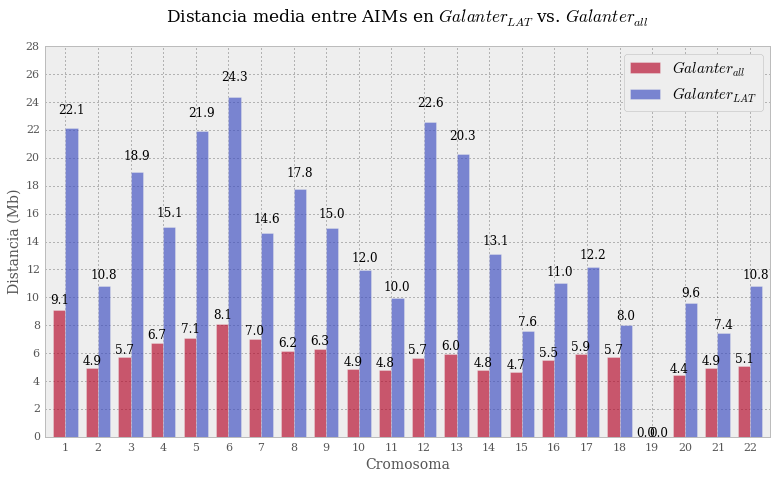

In [15]:
md = snp_distances[['mean_distance_galanter', 'mean_distance_present']]

ax = md.plot(kind='bar', rot=0, width=0.75, colormap=cm.coolwarm_r, alpha=0.65)

ax.set_title(r"Distancia media entre AIMs en $Galanter_{LAT}$ vs. $Galanter_{all}$", y=1.05)
ax.set_ylabel("Distancia (Mb)")
ax.set_xlabel("Cromosoma")

annotate_bars(ax, base=10**6, decimals=1)

yrange = range(0, 30, 2) 
millions = np.array(yrange) * 10**6
ax.set_yticks(millions)
ax.set_yticklabels(yrange)  # Display as Mbp

mdn_galanter = snp_distances.median_distance_galanter
mdn_present = snp_distances.median_distance_present

ax.legend([r"$Galanter_{all}$", r"$Galanter_{LAT}$", ])

plt.show()

#### Discusión

* Las distancias medias son mucho mayores en $Galanter_{LAT}$ que en $Galanter_{all}$. En casos extremos, llega a más de 20 Mpb promedio entre AIMs, cuando esas distancias promedio no superan los 8 Mpb en el panel original.

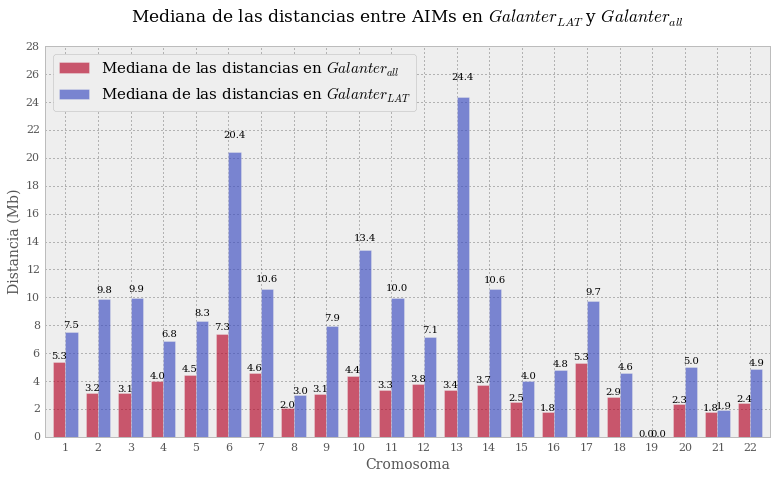

In [16]:
df = snp_distances[['median_distance_galanter', 'median_distance_present']]
ax = df.plot(kind="bar", rot=0, colormap=cm.coolwarm_r, alpha=0.65, width=0.75)

ax.set_title(r"Mediana de las distancias entre AIMs en $Galanter_{LAT}$ y $Galanter_{all}$", y=1.05)
ax.set_ylabel("Distancia (Mb)")
ax.set_xlabel("Cromosoma")

annotate_bars(ax, base=10**6, decimals=1, fontsize=10)

yrange = range(0, 30, 2) 
millions = np.array(yrange) * 10**6
ax.set_yticks(millions)
ax.set_yticklabels(yrange)  # Display as Mbp
ax.legend([r"Mediana de las distancias en $Galanter_{all}$",
           r"Mediana de las distancias en $Galanter_{LAT}$"],
          loc='best')

plt.show()

### Boxplot

In [17]:
d2 = {}

for chrom, distances in SNP_distances_per_chromosome(galanter).items():
    if len(distances) > 1:
        d2[chrom] = np.median(distances)
    else:
        d2[chrom] = None

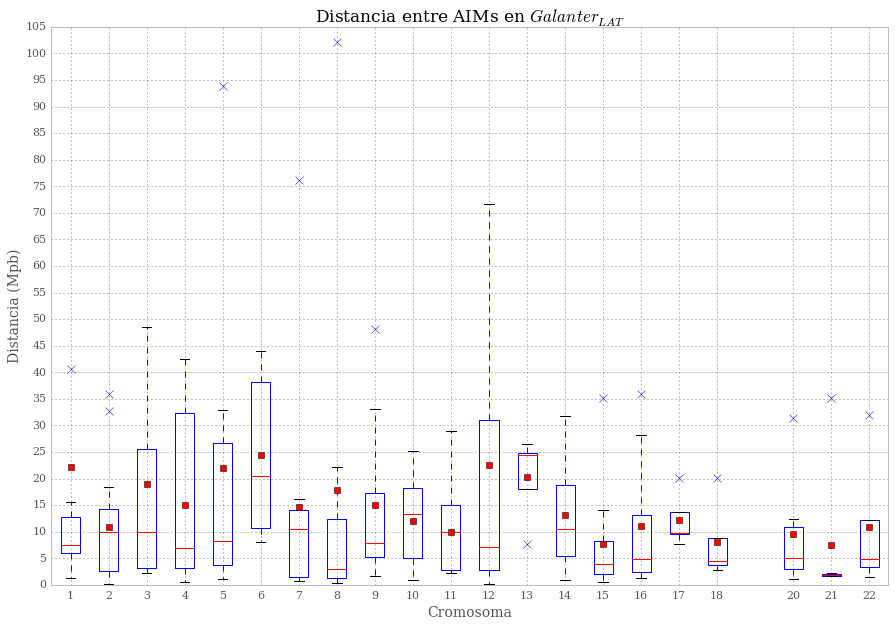

In [108]:
df = SNP_distances_per_chromosome(present)
plt.figure(figsize=(15,10))
ax = plt.subplot(111)

boxes = ax.boxplot(list(df.values()), positions=list(df.keys()),
                   showfliers=True, flierprops={'markersize': 8, 'marker': 'x'},
                   showmeans=True)

y_range = np.arange(0, 110, 5)
millions = [n * 10**6 for n in y_range]
ax.set_yticks(millions)
ax.set_yticklabels(y_range)
ax.set_ylim([millions[0], millions[-1]])

ax.set_title(r"Distancia entre AIMs en $Galanter_{LAT}$")
ax.set_ylabel("Distancia (Mpb)")
ax.set_xlabel("Cromosoma")
ax.set_axis_bgcolor('white')
ax.legend(prop={'size':15})

plt.show()

### Discusión

__Nota__: hay un solo AIM en Galanter para el cromosoma 19, de modo que no se grafican distancias.

* En algunos casos extremos, hay hasta 1.4 Mpb (cromosoma 1) y 1 Mpb (cromosoma 8) de distancia entre dos AIMs contiguos.

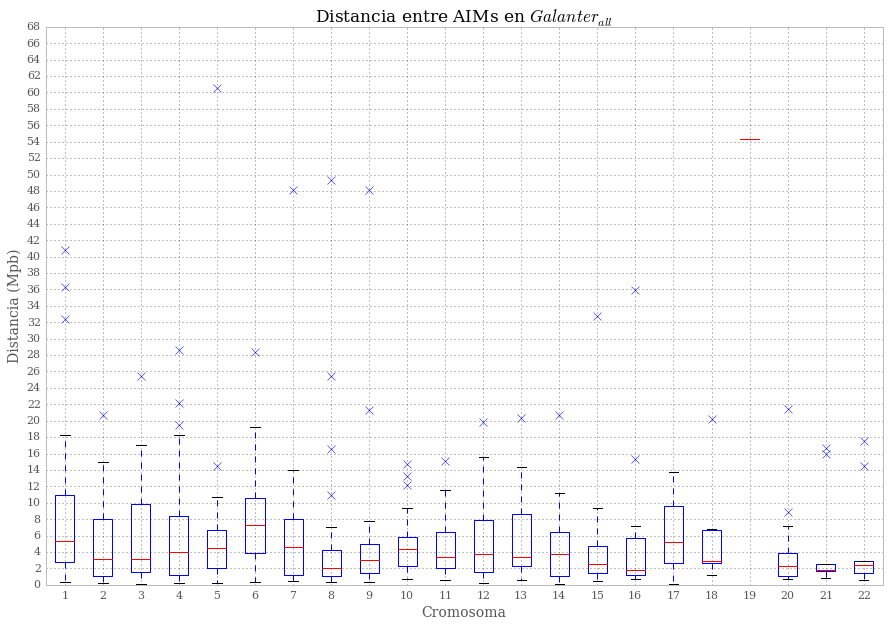

In [19]:
df = SNP_distances_per_chromosome(galanter)
plt.figure(figsize=(15,10))
ax = plt.subplot(111)

boxes = ax.boxplot(list(df.values()), positions=list(df.keys()),
                   showfliers=True, flierprops={'markersize': 8, 'marker': 'x'})

y_range = np.arange(0, 70, 2)
millions = [n * 10**6 for n in y_range]
ax.set_yticks(millions)
ax.set_yticklabels(y_range)
ax.set_ylim([millions[0], millions[-1]])

ax.set_title(r"Distancia entre AIMs en $Galanter_{all}$")
ax.set_ylabel("Distancia (Mpb)")
ax.set_xlabel("Cromosoma")
ax.set_axis_bgcolor('white')
ax.legend(prop={'size':15})

plt.show()

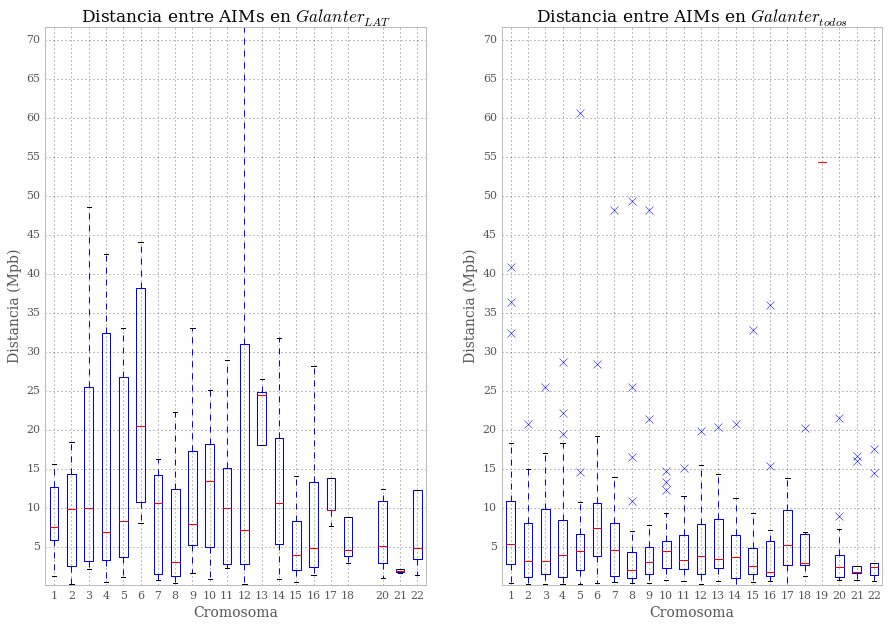

In [20]:
df = SNP_distances_per_chromosome(present)
plt.figure(figsize=(15,10))
ax1 = plt.subplot(121)

boxes = ax1.boxplot(list(df.values()), positions=list(df.keys()),
                   showfliers=False, flierprops={'markersize': 8, 'marker': 'x'})

y_range = np.arange(0, 111, 5)
millions = [n * 10**6 for n in y_range]
ax1.set_yticks(millions)
ax1.set_yticklabels(y_range)
ax1.set_ylim([millions[0], millions[-1]])

ax1.set_title(r"Distancia entre AIMs en $Galanter_{LAT}$")
ax1.set_ylabel("Distancia (Mpb)")
ax1.set_xlabel("Cromosoma")
ax1.set_axis_bgcolor('white')
ax1.legend(prop={'size':15})

df = SNP_distances_per_chromosome(galanter)
ax2 = plt.subplot(122, sharey=ax1)

boxes = ax2.boxplot(list(df.values()), positions=list(df.keys()),
                   showfliers=True, flierprops={'markersize': 8, 'marker': 'x'})

ax2.set_title(r"Distancia entre AIMs en $Galanter_{todos}$")
ax2.set_ylabel("Distancia (Mpb)")
ax2.set_xlabel("Cromosoma")
ax2.set_axis_bgcolor('white')
# ax2.legend(prop={'size':15})

plt.show()

In [67]:
l1 = [list(v) for v in dict(df).values()]
l2 = [list(v) for v in dict(df2).values()]
print(len(l1))
print(len(l2))

21
22


In [97]:
[n for n in zip([1,2],[10,20])]

[(1, 10), (2, 20)]

In [116]:
chromosome = 1
positions = present[present.chr == chromosome].position
print(positions)
distances_between_positions(positions)

SNP rsID
rs6685064       1201155
rs12085319     10952065
rs4920310      18436476
rs2984915      59026283
rs6681578      64786174
rs12727814     71786781
rs12022561     80008407
rs10779334    217173027
rs12142968    232760664
rs7525142     238809528
rs9725312     243105441
Name: position, dtype: int64


[1201155,
 9750910,
 7484411,
 40589807,
 5759891,
 7000607,
 8221626,
 137164620,
 15587637,
 6048864,
 4295913]

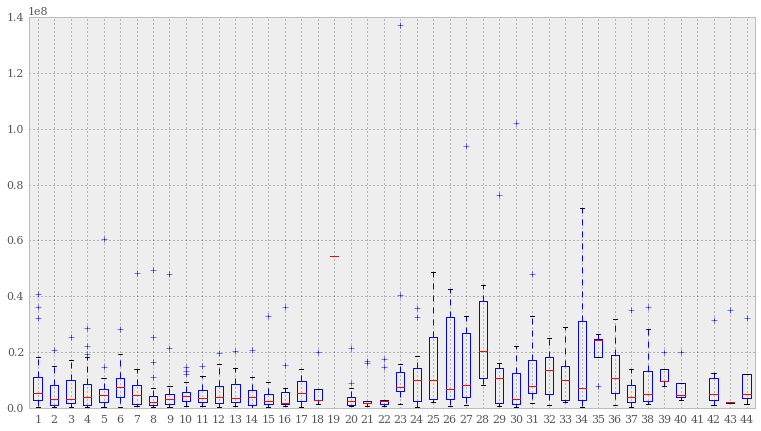

In [101]:


ax = plt.subplot(111)

# ax.boxplot([[1,1,1,1,1,2,25], [10,20,30,40], [5,9,15]])  # Example that works
ax.boxplot(galanter_list + present_list)

plt.show()


### Test para ver si es significativa la diferencia en distribuciones

In [ ]:
from scipy import stats

In [ ]:
# Remove annoying NaN for the test
df = snp_distances.dropna(axis=0, how='any')

In [ ]:
# t_critical, p_value = 
stats.ttest_ind(
    df['mean_distance_galanter'].values,
    df['mean_distance_present'].values, 
)

### Graficar los cromosomas

In [ ]:
galanter_positions = galanter[['chr', 'position']]
present_positions = present[['chr', 'position']]

In [ ]:
# Chromosomes
ax = chr_lengths.plot(kind="barh", width=0.50, figsize=(16, 20),
                      color="b", edgecolor="lightgray", facecolor="snow",
                      linewidth=3, zorder=0, label="Cromosomas")

# Present AIMs
ax.scatter(y=present.chr.values - 1, x=present.position.values, zorder=1,
           marker="|", color="seagreen", linewidth=2, s=600,
           label="Galanter AIMs presentes en LAT")

# Missing AIMs
ax.scatter(y=missing.chr.values - 1, x=missing.position.values, 
           marker="s", color="salmon", alpha=1, linewidth=2, s=7,
           label="Galanter AIMs ausentes en LAT")

ax.set_xlim([0, max_len * 1.05])

ax.set_xlabel("Posición (Mb)")
ax.set_ylabel("Cromosoma")

yinterval = 10**7
ax.set_xticks(np.arange(0, max_len + yinterval, yinterval) // 1)
ax.set_xticklabels(np.arange(0, max_len + yinterval, yinterval) // 10**6)

ax.legend()
plt.show()

# FIXME: bars legend

### Diferenciar por población

In [ ]:
missing_AFR = missing[missing.population == "AFR"]
missing_EUR = missing[missing.population == "EUR"]
missing_NAM = missing[missing.population == "NAM"]
print('{} AFR missing'.format(len(missing_AFR)))
print('{} NAM missing'.format(len(missing_NAM)))
print('{} EUR missing'.format(len(missing_EUR)))

In [ ]:
present_AFR = present[present.population == "AFR"]
present_EUR = present[present.population == "EUR"]
present_NAM = present[present.population == "NAM"]
print('{} AFR present'.format(len(present_AFR)))
print('{} NAM present'.format(len(present_NAM)))
print('{} EUR present'.format(len(present_EUR)))

In [ ]:
# Chromosomes
ax = chr_lengths.plot(kind="barh", width=0.50, figsize=(16, 20),
                      color="b", edgecolor="lightgray", facecolor="snow",
                      linewidth=3, zorder=0, label="Cromosomas")

# Present AIMs
ax.scatter(y=present_AFR.chr.values - 1, x=present_AFR.position.values, zorder=1,
           marker="|", color="black", linewidth=2, s=600,
           label="Galanter AIMs presentes en LAT")
ax.scatter(y=present_EUR.chr.values - 1, x=present_EUR.position.values, zorder=1,
           marker="|", color="steelblue", linewidth=2, s=600,
           label="Galanter AIMs presentes en LAT")
ax.scatter(y=present_NAM.chr.values - 1, x=present_NAM.position.values, zorder=1,
           marker="|", color="chocolate", linewidth=2, s=600,
           label="Galanter AIMs presentes en LAT")

# Missing AIMs
ax.scatter(y=missing.chr.values - 1, x=missing.position.values, 
           marker="s", color="salmon", alpha=1, linewidth=2, s=7,
           label="Galanter AIMs ausentes en LAT")

ax.set_xlim([0, max_len * 1.05])

ax.set_xlabel("Posición (Mb)")
ax.set_ylabel("Cromosoma")

yinterval = 10**7
ax.set_xticks(np.arange(0, max_len + yinterval, yinterval) // 1)
ax.set_xticklabels(np.arange(0, max_len + yinterval, yinterval) // 10**6)

ax.invert_yaxis()
ax.tick_params(labeltop="on")

ax.legend(prop={'size': 17}, loc="center right")
plt.show()

# FIXME: bars legend

**TODO**: Conseguir las longitudes cromosomales exactas, el #3 parece estar mal

In [ ]:
num_format(missing[missing.chr == 3].position.max())

In [ ]:
num_format(chr_lengths.loc[3, 'total_length'])

**TODO**: Visualize with special software, tipo http://visualization.ritchielab.psu.edu/phenograms/examples

## Diferenciar por población de referencia, present vs galanter

In [ ]:
galanter_population_ratios = galanter.population.value_counts() / \
                             galanter.population.count()
galanter_population_ratios

In [ ]:
present_population_ratios = present.population.value_counts() / \
                            present.population.count()
present_population_ratios    

In [ ]:
figure, axes = plt.subplots(1, 2)

# RATIOS
pop_ratios = pd.DataFrame({
    'present_population_ratios': present_population_ratios,
    'galanter_population_ratios': galanter_population_ratios
})

ax1 = pop_ratios.plot(ax=axes[0], kind="bar", color=['steelblue', 'lightgreen'], rot=0)
ax1.set_ylabel("Proporción")
ax1.set_xlabel("Población")
ax1.set_title("Proporción de AIMs de cada población\nen $Galanter_{todos}$ vs. $Galanter_{LAT-1}$",
             y=1.025)
ax1.set_ylim([0, 1])
ax1.legend(["$Galanter_{todos}$", "$Galanter_{LAT-1}$"])

annotations = annotate_bars(ax1, decimals=2, fontsize=12)

# COUNTS
pop_count = pd.DataFrame({
    'present_by_population': present.population.value_counts(),
    'missing_by_population': missing.population.value_counts(),
#     'galanter_by_population': galanter.population.value_counts()
})

ax2 = pop_count.plot(ax=axes[1], kind="bar", color=['tomato', 'lightgreen'], rot=0)
ax2.set_ylabel("% de AIMs en cada panel")
ax2.set_xlabel("Población")
ax2.set_ylim([0, 150])
ax2.set_title("Galanter AIMs presentes vs. ausentes\nen LAT-1, por población", y=1.025)
ax2.legend(["$Galanter_{\sim LAT-1}$", "$Galanter_{LAT-1}$"])

annotations = annotate_bars(ax2, decimals=0)

plt.show()

### Discusión

* Los AIMs de Galaner presentes en LAT-1 tienen proporciones poblacionales diferentes a las proporciones del total del panel. En $Galanter_{LAT-1}$
    - la proporción de AFR es .08 mayor
    - la proporción de EUR es .06 menor
    - la proporción de NAM es .03 menor
* Problema: El hecho de que nos quedemos con más AFR en proporción y menos EUR afectará la predición?

**TODO**: mergear estos dos últimos gráficos o al menos ponerlos lado a lado en la misma figure

# Frecuencias poblacionales

Download script:

In [ ]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

Descomprimir cada \*.vcf.gz con **`bgzip -d <vcf.gz file>`**

### Extraer los AIMs de interés de los \*.vcf de cromosomas completos

In [ ]:
from glob import glob
import os

def chr_file(chr):
    return ("ALL.chr{}.phase3_shapeit2_mvncall_integrated_v5a"
            ".20130502.genotypes.vcf.gz".format(chr))

def vcf_extract_command(chromosome):
    command = ("vcftools --gzvcf {chr_file} --snps {snps_file} "
               "--recode --keep-INFO-all --out chr_{chr}_SNPs")
    return command.format(**{
        'chr_file': chr_file(chromosome),
#         'snps_file': "galanter_snps_in_chr{}".format(chromosome),
        'snps_file': "galanter_snps",
        'chr': chromosome
    })

os.chdir("/home/juan/tesina/1000genomes")

rs_IDs = galanter.index.values
filename = "galanter_snps"
with open(filename, "w") as f:
    [f.write(rs + "\n") for rs in rs_IDs]

commands = []    
for chromosome in galanter.chr.unique():
#     filename = "galanter_snps_in_chr{}".format(chromosome)
#     rs_IDs = galanter[galanter.chr == chromosome].index.values
    commands.append(vcf_extract_command(chromosome))

In [ ]:
commands[0].split()

In [ ]:
print("""
    I used this cell to extract all Galanter SNPs from the huge compressed
    *.vcf.gz files from 1000genomes. It was a one time run, unnecessary now.
    The *.recode.* files are generated and then you use those.
    Just keeping the code in case I need it again.
""")

# import subprocess

# for command in commands:
#     print(command)
#     subprocess.call(command.split())  # WARNING: This takes a while

## Leer el .vcf de cada AIM y obtener sus frecuencias

### Población de cada muestra

Ejemplo de la data de subpoblaciones que busco, para rs2585897:

http://browser.1000genomes.org/Homo_sapiens/Variation/Population?db=core;r=13:21398479-21399479;v=rs2585897;vdb=variation;vf=2188197

In [ ]:
fn = "/home/juan/tesina/1000genomes/integrated_call_samples_v3.20130502.ALL.panel"
samples = pd.read_table(fn)
samples = samples.dropna(axis=1, how='all')
samples = samples.rename(columns={'pop': 'population', 'super_pop': 'super_population'})
samples = samples.set_index('sample')
samples.head(1)

### Leer los .vcf de 1000 genomas (filtrados por Galanter) 

In [ ]:
# TODO: get this in a .py script!
# https://pyvcf.readthedocs.org/en/latest/API.html#vcf-model-record

import vcf
import itertools


def vcf_record_to_dict(record):
    data = {}
    attributes = ['ID', 'CHROM', 'POS', 'REF', 'ALT', 'QUAL',
                  'FILTER', 'FORMAT', 'alleles', 'nucl_diversity',
                  'call_rate', 'heterozygosity', 'is_transition',
                  'var_subtype', 'var_type', 'samples']
    data = dict([(key, getattr(record, key)) for key in attributes])
    data['samples_genotypes'] = [(s.sample, s.gt_type) for s in data['samples']]
    del(data['samples'])
    data.update(record.INFO)  # record.INFO is already a dict
    return data

def vcf_to_dataframe(filename):
    vcf_reader = vcf.Reader(open(filename, 'r'))
    records = [vcf_record_to_dict(r) for r in vcf_reader]
    df = pd.DataFrame(records)
    df = df.set_index('ID')
    return df

def vcf_records(vcf_filename):
    """Returns a list of records read from a vcf filename"""
    return list(vcf.Reader(open(vcf_filename, 'r')))

# Gather all the .vcf Records from the files
vcf_filenames = glob("chr_*recode*")
records = [vcf_records(vcf) for vcf in vcf_filenames]
records = itertools.chain.from_iterable(records)  # Flattens the list of lists
records_as_dictionaries = [vcf_record_to_dict(r) for r in records]

df_1000genomes = pd.DataFrame(records_as_dictionaries).set_index('ID')
df_1000genomes = df_1000genomes.dropna(axis=1)
df_1000genomes = df_1000genomes.drop('FILTER', axis=1)

# Remove unnecessary lists of one element
for field_name, s in df_1000genomes.iteritems():
    if not s.map(lambda e: type(e) == list).all():
        continue
    if all([len(e) == 0 for e in s]):
#     if s.map(lambda e: len(e) == 0).all():
        df_1000genomes.drop(field_name, axis=1)
#     if s.map(lambda e: str(e).startswith('[')).all():
    if all([type(e) == 'list' for e in s]):
        df_1000genomes[field_name] = s.map(lambda e: e[0])

df_1000genomes

### Convertir 'samples_genotypes' en frecuencias poblacionales!

In [ ]:
genotypes = df_1000genomes['samples_genotypes']
genotypes.head(2)

In [ ]:
from collections import defaultdict, OrderedDict

def snp_genotypes_to_allele_freqs(snp_genotypes):
    """Returns a dict with { population_1 : ref_allele_frequency,
    population_2: ... }"""
    
    allele_count = defaultdict(lambda: [0, 0])
    codes = {0: 'ref_homocygote', 1: 'heterocygote', 2: 'alt_homocygote'}
    for sample_name, genotype_code in snp_genotypes:
        population = samples.loc[sample_name].population
        if codes[genotype_code] == 'ref_homocygote':
            allele_count[population][0] += 2
        elif codes[genotype_code] == 'heterocygote':
            allele_count[population][0] += 1
            allele_count[population][1] += 1
        elif codes[genotype_code] == 'alt_homocygote':
            allele_count[population][1] += 2

    freq = {}
    for population, (ref_allele_count, alt_allele_count) in allele_count.items():
        total_alleles = ref_allele_count + alt_allele_count
        freq[population] = round(ref_allele_count / total_alleles, 2)

    return freq

In [ ]:
dump_filename = "galanter_snps_frequencies_in_1000genomes.csv"

if os.path.isfile(dump_filename):
    subpopulation_freqs = pd.read_csv(dump_filename, index_col='ID')
else:
    # This takes a while
    freqs_as_dicts = genotypes.apply(snp_genotypes_to_allele_freqs)
    subpopulation_freqs = pd.DataFrame(freqs_as_dicts.values.tolist(),
                                       index=freqs_as_dicts.index)
    subpopulation_freqs.to_csv(dump_filename)

In [ ]:
superpopulation_freqs = df_1000genomes.filter(regex="AF")
for field in superpopulation_freqs:
    float_series = superpopulation_freqs[field].apply(lambda x: round(x[0],2))
    superpopulation_freqs[field] = float_series

In [ ]:
frequencies_1000g = pd.concat([subpopulation_freqs, superpopulation_freqs], axis=1)
frequencies_1000g = frequencies_1000g.rename(columns={
    'AFR_AF': 'AFR', 'AMR_AF': 'AMR', 'EAS_AF': 'EAS',
    'EUR_AF': 'EUR', 'SAS_AF': 'SAS'})

# Comparar los dos dataframes: Galanter y 1000Genomes

### Comparar SNPs

In [ ]:
print(len(df_1000genomes))
print(len(galanter))

TODO: Quién falta?

### Chequear AF

### Ver qué subpoblaciones se van en $Galanter_{missing}$ y cuáles quedan

In [ ]:
dumpfile = "population_names.csv"

if os.path.isfile(dumpfile):
    population_names = pd.read_csv(dumpfile, index_col='Population Code')
else:
    url = "http://www.1000genomes.org/category/frequently-asked-questions/population"
    df = pd.read_html(url)[0]  # First table in the page
    df.columns = df.iloc[0]
    df = df.iloc[1:, :3].set_index('Population Code')
    df.to_csv(dumpfile)
    population_names = df

population_names.head(1)

In [ ]:
def whois(pop_code):
    return population_names.loc[pop_code]['Population Description']

In [ ]:
whois('ACB')

In [ ]:
def plot_mean_freqs(df, title=""):
    df = df.join(frequencies_1000g).iloc[:, 4:].drop(['LSBL(Fst)', 'LSBL(In)'], axis=1)
    ax = df.mean().plot(kind='bar', color='cornflowerblue', figsize=(18,6), width=0.75)
    for bar in ax.patches[:3]:
        bar.set_color('coral')
    for bar in ax.patches[-6:]:
        bar.set_color('coral')
    ax.set_ylim(0,1)
    ax.set_title(title)
    ax.axhline(0.5, color='k', linestyle='--')
    annotate_bars(ax, decimals=2, fontsize=10)
    plt.show()

In [ ]:
plot_mean_freqs(missing, 'Promedio de frecuencias alélicas en $Galanter_{OUT}$, por población')

In [ ]:
plot_mean_freqs(galanter, 'Promedio de frecuencias alélicas en $Galanter_{total}$, por población')

In [ ]:
plot_mean_freqs(present, 'Promedio de frecuencias alélicas en $Galanter_{LAT-1}$, por población')

#### t test para comparar las dos series

In [ ]:
extract_mean_freqs = lambda df: df.join(frequencies_1000g).iloc[:, 11:-6].mean()

galanter_mean_frequencies = extract_mean_freqs(galanter)
missing_mean_frequencies = extract_mean_freqs(missing)
present_mean_frequencies = extract_mean_freqs(present)

# t-test assumes equal variances between the two sets?

print(galanter_mean_frequencies.var())
print(missing_mean_frequencies.var())

In [ ]:
import scipy

ntest, p_val = scipy.stats.mstats.normaltest(present_mean_frequencies)
print("Galanter missing:")
m("$p = {}$".format(round(p_val,3)))

ntest, p_val = scipy.stats.mstats.normaltest(galanter_mean_frequencies)
print("Galanter_total:")
m("$p = {}$".format(round(p_val, 3)))

>the farther away the observed or measured sample mean is from the hypothesized mean, the lower the probability (i.e., the p-value) that the null hypothesis is true.

* $Galanter_{total}$ tiene un p-value bajo (0.01), de modo que la $H_0$ no parece verdadera. Es decir, $Galanter_{total}$ no estaría normalmente distribuido.
* $Galanter_{missing}$, por otro lado, tiene un p-value más alto (0.10), pero no tanto, de modo que al menos con una confianza del 90% podemos decir que no está normalmente distribuido.
* Lo que no entiendo del todo es qué implicaría que sí (o que no) esté normalmente distribuido para el panel de Galanter. La selección de SNPs no es azarosa, por qué habríamos de esperar eso?

In [ ]:
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, 10000)
ntest, p_val = scipy.stats.mstats.normaltest(s)
print(ntest, p_val)

In [ ]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(galanter_mean_frequencies, present_mean_frequencies)
print("t = {}".format(round(t_stat, 2)))
print("p_value = {}".format(round(p_val, 2)))

In [ ]:
ax = plt.subplot(111)
ax.hist(galanter_mean_frequencies, 10, alpha=.6)
ax.hist(missing_mean_frequencies, 20, alpha=.6)
ax.legend(["$Galanter_{total}$", "$Galanter_{LAT-1}$"])
plt.show()

### Discusión

* El panel completo $Galanter_{total}$ está balanceado en cuanto a frecuencias alélicas por población: la mayoría se ubica en un promedio de alrededor de 0.57, para cada subpoblación, con un desvío muy bajo: 0.013.
* Ninguna subpoblación parece haber sido afectada en particular por la subselección de SNPs. Todas las frecuencias alélicas se mantienen entre 0.5 y 0.6, rango que incluye también a todas las frecuencias por subpoblación del panel original.
* El t-test ? Si la $H_0$ es que ambas medias son estadíticamente iguales, entonces se confirmó?

### Comparar posiciones (Galanter las tiene diferentes?)

In [ ]:
positions = galanter[['chr', 'position']].join(df_1000genomes[['CHROM', 'POS']])
positions.columns = ['chr_galanter', 'pos_galanter', 'chr_1000g', 'pos_1000g']
positions.head(1)

In [ ]:
positions['pos_diff'] = positions['pos_galanter'] - positions['pos_1000g']

In [ ]:
positions.head()

In [ ]:
galanter_heter = galanter.join(df_1000genomes, rsuffix='_').heterozygosity
missing_heter = missing.join(df_1000genomes, rsuffix='_').heterozygosity

ax = plt.subplot(111)
ax.boxplot([galanter_heter, missing_heter])
ax.set_xticklabels([
    '$Galanter_{total}$',
    '$Galanetr_{LAT-1}$',
])
plt.show()